In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM, SimpleRNN, Dense, Input
from keras.models import Sequential
import tensorflow.keras.optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
import torch
import torch.nn as nn
from torch.autograd import Variable
import math, random

Text(0.5, 0.98, 'Saw_tooth signal')

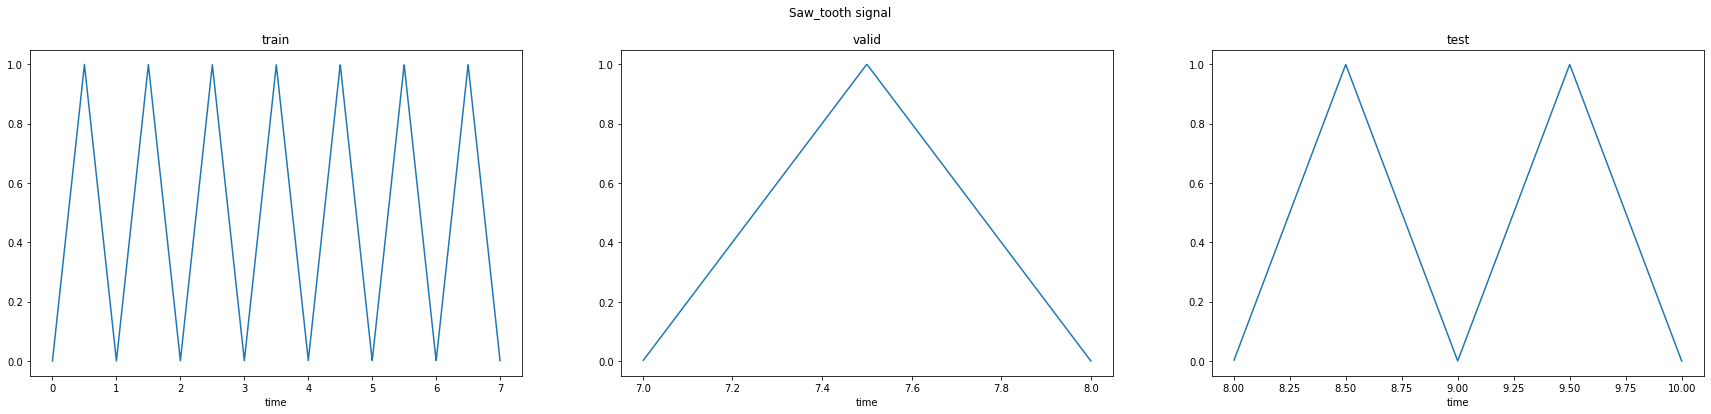

In [143]:
t = np.linspace(0, 10, 5000)
signal1 = (1+signal.sawtooth(2 * np.pi * t, width=0.5))/2
train, time_train = signal1[:7*500], t[:7*500]
valid, time_valid = signal1[7*500:8*500], t[7*500:8*500]
test, time_test = signal1[8*500:], t[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'train')
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'valid')
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'test')
fig.suptitle('Saw_tooth signal')

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

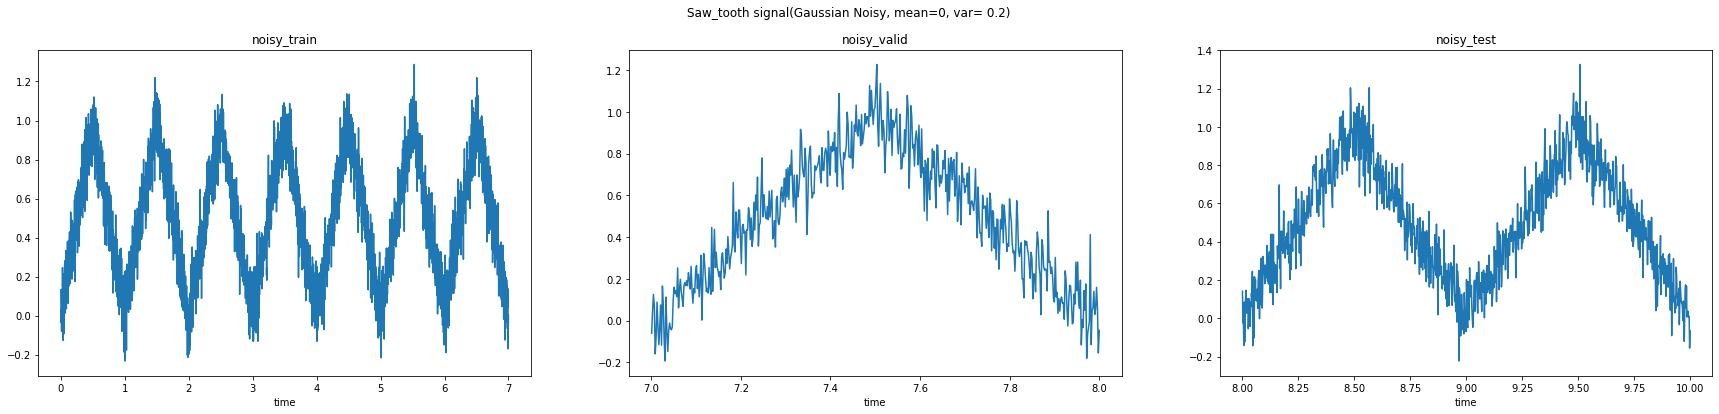

In [144]:
noise = np.random.normal(0, 0.1, 5000)
noisy_train = train + noise[:7*500]
noisy_valid = valid + noise[7*500:8*500]
noisy_test = test + noise[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, noisy_train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[1].plot(time_valid, noisy_valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[2].plot(time_test, noisy_test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

Text(0.5, 0.98, 'Saw_tooth signal(Uniform noisy))')

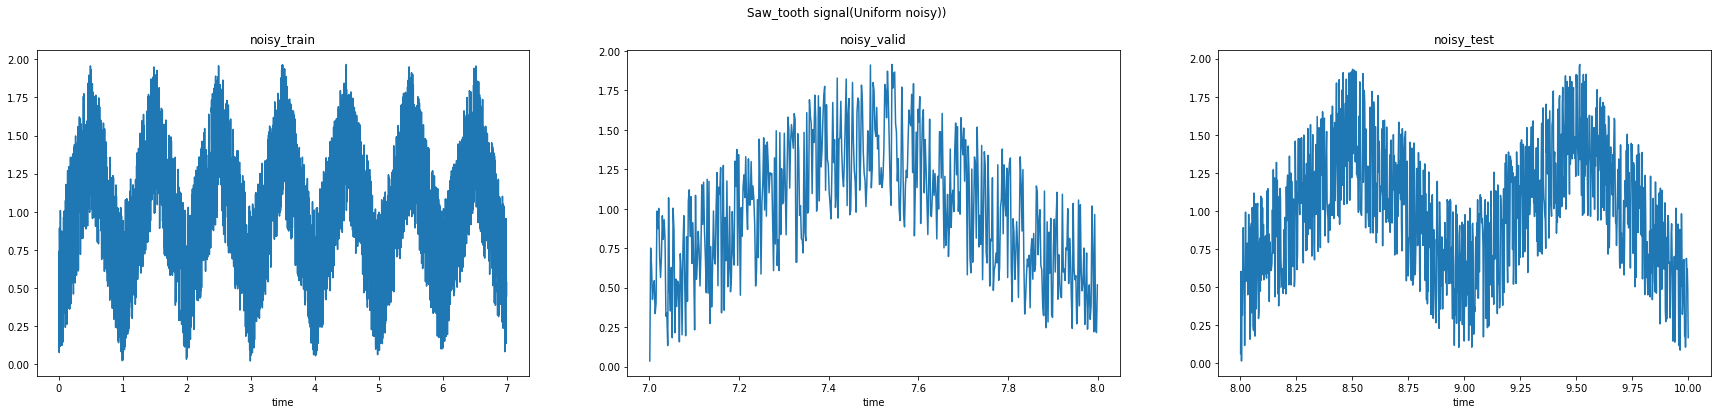

In [4]:
noise2 = np.random.uniform(0, 1, 5000)
noisy_train2 = train + noise2[:7*500]
noisy_valid2 = valid + noise2[7*500:8*500]
noisy_test2 = test + noise2[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, noisy_train2)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[1].plot(time_valid, noisy_valid2)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[2].plot(time_test, noisy_test2)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
fig.suptitle('Saw_tooth signal(Uniform noisy))')

# Preparing Data

In [227]:
def saw(X, signal_freq=500.):
    return (1+signal.sawtooth(2 * np.pi * (X)/signal_freq, width=0.5))/2

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.normal(0, 0.1, 500)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out

# Models : (RNN)

In [222]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [164]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0158, valid_loss = 0.1313
epoch : 2, train_loss = 0.0028, valid_loss = 0.1425
epoch : 4, train_loss = 0.0023, valid_loss = 0.1707
epoch : 6, train_loss = 0.0025, valid_loss = 0.1218
epoch : 8, train_loss = 0.0022, valid_loss = 0.2011
epoch : 10, train_loss = 0.0020, valid_loss = 0.1806
epoch : 12, train_loss = 0.0021, valid_loss = 0.1159
epoch : 14, train_loss = 0.0020, valid_loss = 0.1738
epoch : 16, train_loss = 0.0019, valid_loss = 0.1845
epoch : 18, train_loss = 0.0020, valid_loss = 0.1486


In [178]:
inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
out = Variable(torch.Tensor(test.reshape((2, -1, 1))))
pred = r(inp)

loss = loss_func(pred, out)
test_loss = loss.data.numpy().sum()

print(f'loss on test: {test_loss}')

loss on test: 0.0024264338426291943


In [185]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

## Plots

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

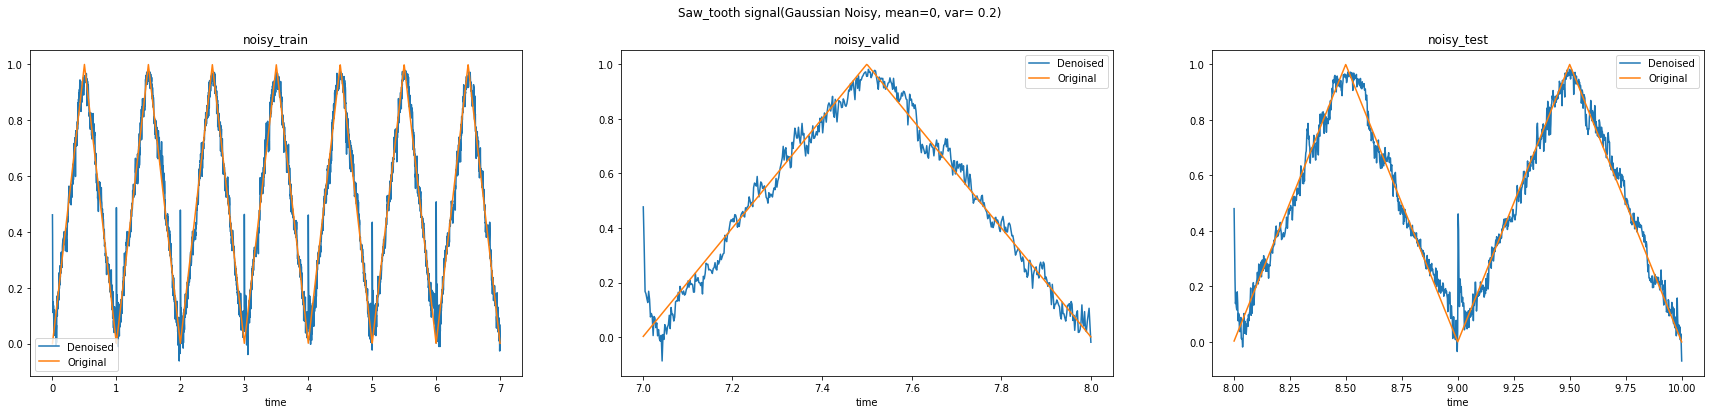

In [187]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

## SNR's

In [199]:
snr_train = 10*np.log10(np.mean(np.square(train))/ (np.mean(np.square(train-train_pred))))
snr_valid = 10*np.log10(np.mean(np.square(valid))/ (np.mean(np.square(valid-valid_pred))))
snr_test = 10*np.log10(np.mean(np.square(test))/ (np.mean(np.square(test-test_pred))))
print(f'SNR\'s for Train = {snr_train}\n \
        validation = {snr_valid} \n \
        test = {snr_test}') 

SNR's for Train = 21.504974967874833
         validation = 21.333390395218395 
         test = 21.2718015272962


# Models : (LSTM)

In [226]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, (h, c) = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [228]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0184, valid_loss = 0.1732
epoch : 2, train_loss = 0.0026, valid_loss = 0.1607
epoch : 4, train_loss = 0.0022, valid_loss = 0.1420
epoch : 6, train_loss = 0.0019, valid_loss = 0.1549
epoch : 8, train_loss = 0.0016, valid_loss = 0.1832
epoch : 10, train_loss = 0.0013, valid_loss = 0.1459
epoch : 12, train_loss = 0.0012, valid_loss = 0.1478
epoch : 14, train_loss = 0.0011, valid_loss = 0.1867
epoch : 16, train_loss = 0.0010, valid_loss = 0.1329
epoch : 18, train_loss = 0.0009, valid_loss = 0.1666


In [229]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

## Plots

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

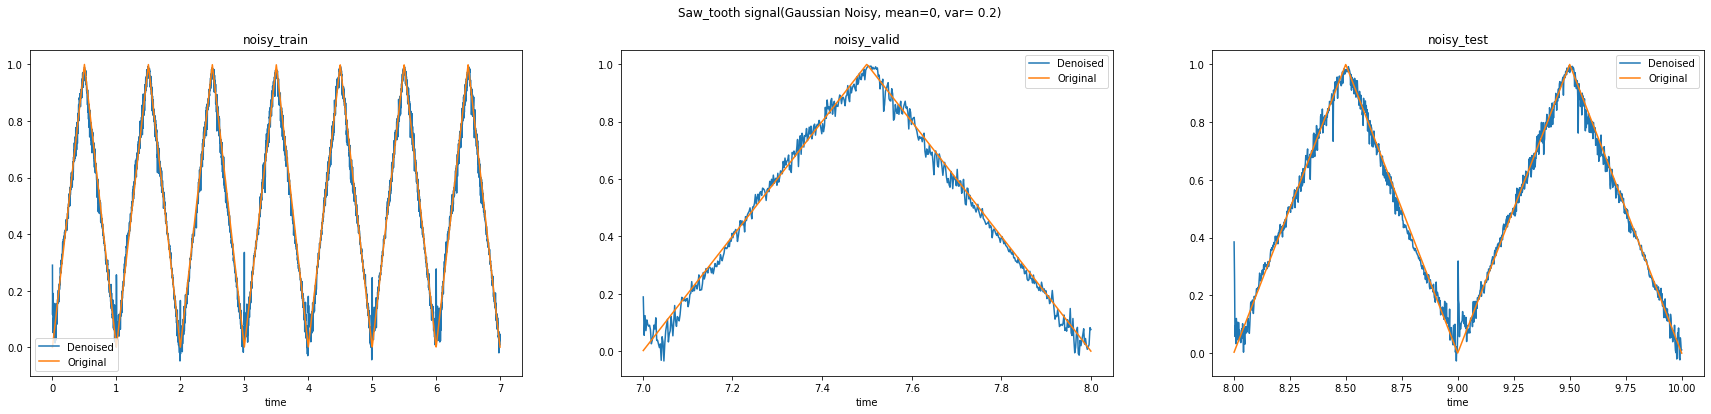

In [230]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

## SNR's

In [231]:
snr_train = 10*np.log10(np.mean(np.square(train))/ (np.mean(np.square(train-train_pred))))
snr_valid = 10*np.log10(np.mean(np.square(valid))/ (np.mean(np.square(valid-valid_pred))))
snr_test = 10*np.log10(np.mean(np.square(test))/ (np.mean(np.square(test-test_pred))))
print(f'SNR\'s for Train = {snr_train}\n \
        validation = {snr_valid} \n \
        test = {snr_test}') 

SNR's for Train = 25.758465508966957
         validation = 25.53496580829185 
         test = 24.879716461881955


# Effect of variance

## Var = 0.7

In [213]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0394, valid_loss = 0.1587
epoch : 2, train_loss = 0.0196, valid_loss = 0.1550
epoch : 4, train_loss = 0.0184, valid_loss = 0.1667
epoch : 6, train_loss = 0.0183, valid_loss = 0.1310
epoch : 8, train_loss = 0.0175, valid_loss = 0.1284
epoch : 10, train_loss = 0.0170, valid_loss = 0.1960
epoch : 12, train_loss = 0.0173, valid_loss = 0.1372
epoch : 14, train_loss = 0.0182, valid_loss = 0.1234
epoch : 16, train_loss = 0.0179, valid_loss = 0.1452
epoch : 18, train_loss = 0.0172, valid_loss = 0.1663


In [214]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

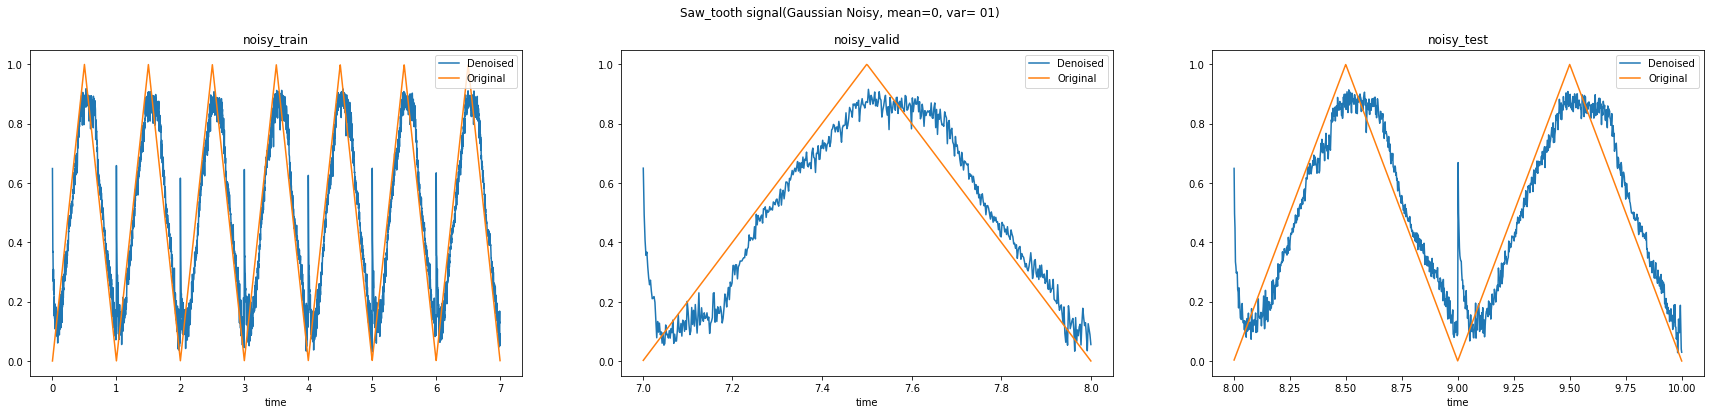

In [215]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Var = 0.9

In [208]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0395, valid_loss = 0.1687
epoch : 2, train_loss = 0.0255, valid_loss = 0.1388
epoch : 4, train_loss = 0.0248, valid_loss = 0.1496
epoch : 6, train_loss = 0.0240, valid_loss = 0.1117
epoch : 8, train_loss = 0.0225, valid_loss = 0.1536
epoch : 10, train_loss = 0.0237, valid_loss = 0.1421
epoch : 12, train_loss = 0.0230, valid_loss = 0.1538
epoch : 14, train_loss = 0.0231, valid_loss = 0.1253
epoch : 16, train_loss = 0.0226, valid_loss = 0.0903
epoch : 18, train_loss = 0.0220, valid_loss = 0.1074


In [209]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

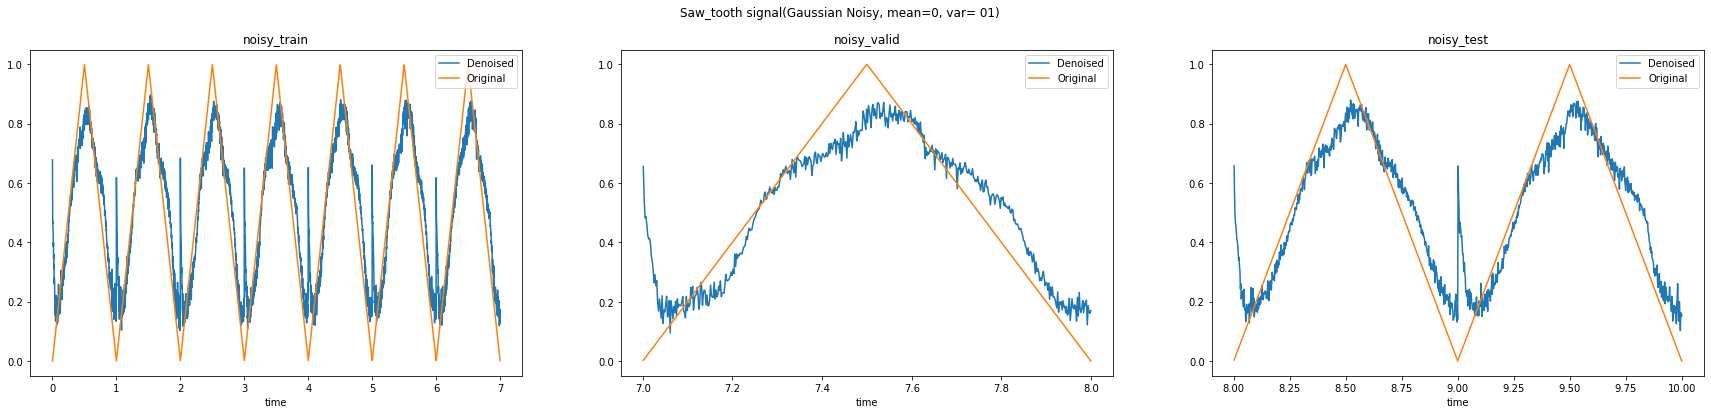

In [210]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Var = 1

In [202]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0450, valid_loss = 0.1375
epoch : 2, train_loss = 0.0277, valid_loss = 0.1531
epoch : 4, train_loss = 0.0274, valid_loss = 0.1126
epoch : 6, train_loss = 0.0292, valid_loss = 0.1430
epoch : 8, train_loss = 0.0263, valid_loss = 0.1260
epoch : 10, train_loss = 0.0258, valid_loss = 0.1018
epoch : 12, train_loss = 0.0248, valid_loss = 0.1207
epoch : 14, train_loss = 0.0259, valid_loss = 0.1328
epoch : 16, train_loss = 0.0247, valid_loss = 0.1210
epoch : 18, train_loss = 0.0248, valid_loss = 0.1673


In [203]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

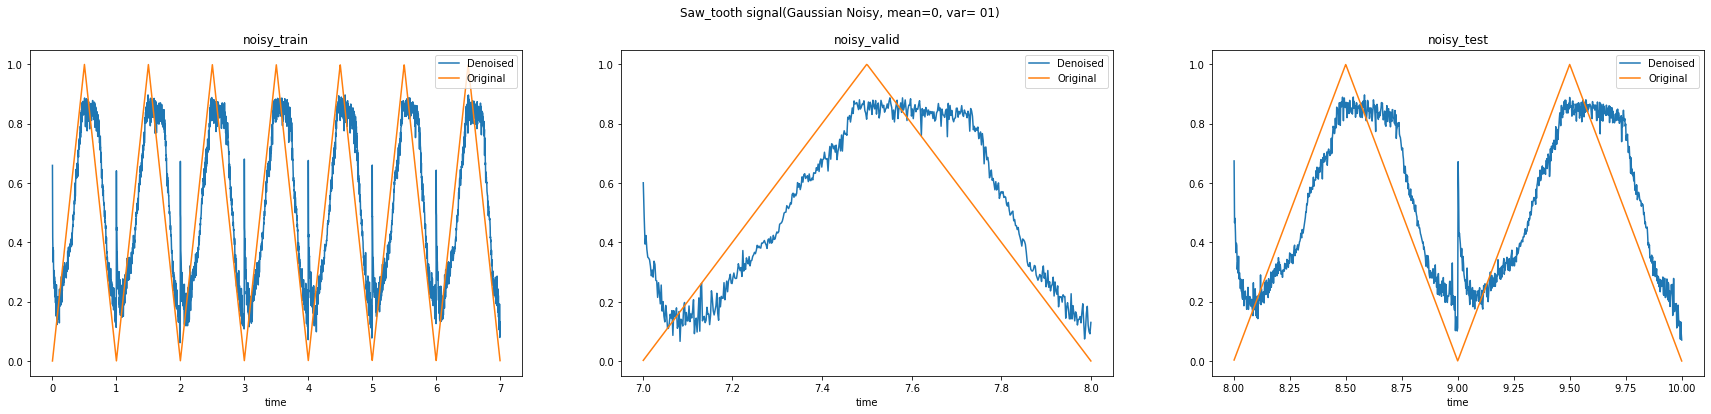

In [205]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## var = 1.4

In [218]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0579, valid_loss = 0.1575
epoch : 2, train_loss = 0.0451, valid_loss = 0.1331
epoch : 4, train_loss = 0.0448, valid_loss = 0.1234
epoch : 6, train_loss = 0.0405, valid_loss = 0.1159
epoch : 8, train_loss = 0.0437, valid_loss = 0.0997
epoch : 10, train_loss = 0.0425, valid_loss = 0.1153
epoch : 12, train_loss = 0.0401, valid_loss = 0.1258
epoch : 14, train_loss = 0.0388, valid_loss = 0.1163
epoch : 16, train_loss = 0.0400, valid_loss = 0.1173
epoch : 18, train_loss = 0.0380, valid_loss = 0.1060


In [219]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

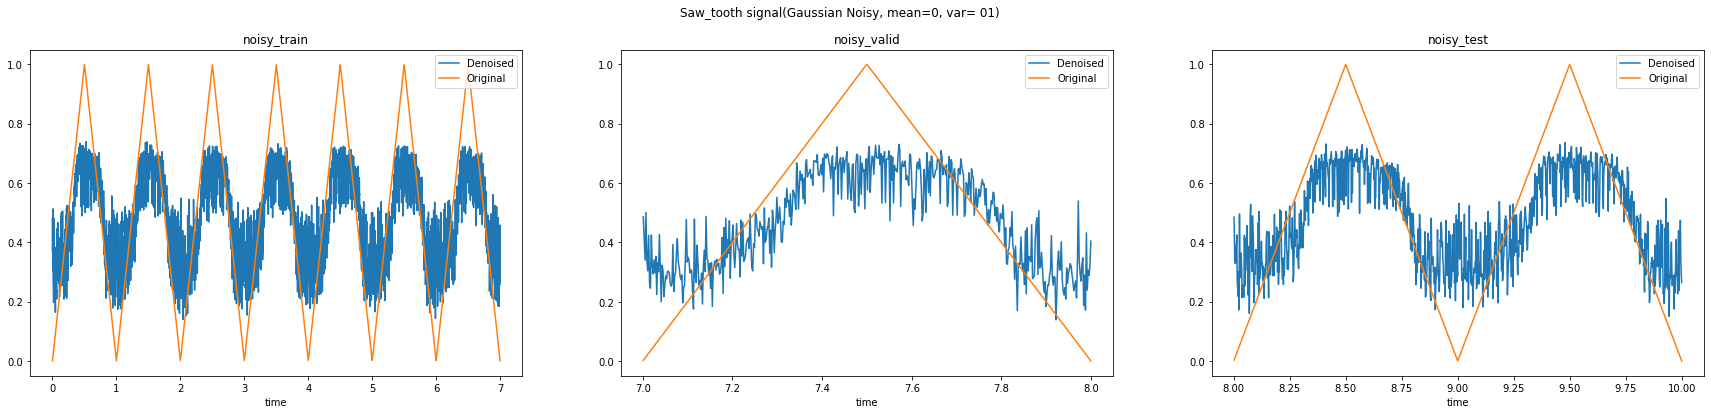

In [220]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Var = 1.8

In [223]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0662, valid_loss = 0.1061
epoch : 2, train_loss = 0.0615, valid_loss = 0.1461
epoch : 4, train_loss = 0.0814, valid_loss = 0.0845
epoch : 6, train_loss = 0.0824, valid_loss = 0.0840
epoch : 8, train_loss = 0.0811, valid_loss = 0.0858
epoch : 10, train_loss = 0.0822, valid_loss = 0.0841
epoch : 12, train_loss = 0.0811, valid_loss = 0.0853
epoch : 14, train_loss = 0.0789, valid_loss = 0.0869
epoch : 16, train_loss = 0.0822, valid_loss = 0.0858
epoch : 18, train_loss = 0.0829, valid_loss = 0.0854


In [224]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

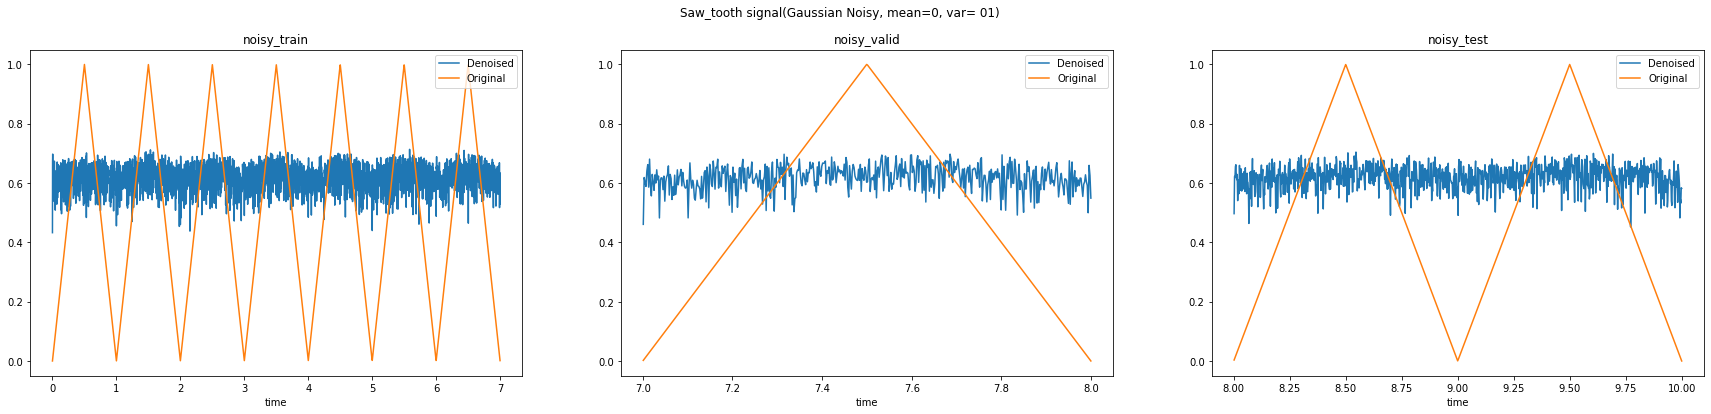

In [225]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')